In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000055_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000372_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000241_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000206_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000042_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000073_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000325_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000320_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000238_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000278_resized.png
/kaggle/input/themassiveindianfooddataset/Jalebi-Resize/Jalebi-Resize/00000186_resized.png

In [5]:
# The data in comparison to the Original Data has been reduced to 10%
# This clearly means that there is substantially less training data and the
import os
for dirpath,dirnames,filenames in os.walk("themassiveindianfooddataset"):
    print(f"There are {len(dirnames)} Directories and {len(filenames)} Files in '{dirpath}'")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting up Global Variables for better Re-usability
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_dir="../input/themassiveindianfooddataset/"
train_data_generator=ImageDataGenerator(rescale=1/255.)
# test_data_generator=ImageDataGenerator(rescale=1/255.)
train_data=train_data_generator.flow_from_directory(train_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")

Found 3009 images belonging to 8 classes.


In [7]:
# Function as we need to modularize it to be reusable for all the
# Also we will be saving them to the log_dir for all the Different models we built
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [8]:
train_data

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"



In [12]:
# Function to Create a Model from an Input url
# 3 Classes as this starter Notebook is made on the Initial Dataset
def create_model(model_url, num_classes=8):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           # freeze the underlying patterns
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           # define the input image shape
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create our own model using the feature extraction layer as the base
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [13]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

2022-01-27 10:00:44.674213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 10:00:44.784077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 10:00:44.785153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 10:00:44.787147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
# Fitting the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=6,
                                  steps_per_epoch=len(train_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  # save experiment logs here
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         # name of log files
                                                                         experiment_name="resnet50V2")]) 

2022-01-27 10:00:55.700453: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 10:00:55.700650: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-27 10:00:55.702863: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-27 10:00:55.965553: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-27 10:00:55.965764: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220127-100055


2022-01-27 10:00:56.588823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6


2022-01-27 10:01:01.798071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/95 [..............................] - ETA: 16:50 - loss: 2.4244 - accuracy: 0.1562

2022-01-27 10:01:07.769341: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 10:01:07.769397: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/95 [..............................] - ETA: 1:09 - loss: 2.2824 - accuracy: 0.2500 

2022-01-27 10:01:08.128638: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-27 10:01:08.129825: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-27 10:01:08.279896: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 339 callback api events and 336 activity events. 
2022-01-27 10:01:08.296326: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-27 10:01:08.326586: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27_10_01_08



 3/95 [..............................] - ETA: 51s - loss: 2.3403 - accuracy: 0.2083 

2022-01-27 10:01:08.338793: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27_10_01_08/5f62edc346e4.trace.json.gz
2022-01-27 10:01:08.402137: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27_10_01_08

2022-01-27 10:01:08.412139: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27_10_01_08/5f62edc346e4.memory_profile.json.gz
2022-01-27 10:01:08.414133: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27_10_01_08
Dumped tool data for xplane.pb to tensorflow_hub/resnet50V2/20220127-100055/train/plugins/profile/2022_01_27

37/95 [==========>...................] - ETA: 19s - loss: 1.2469 - accuracy: 0.5819

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


95/95 [==============================] - 41s 326ms/step - loss: 0.8381 - accuracy: 0.7162
Epoch 2/6
95/95 [==============================] - 21s 222ms/step - loss: 0.3562 - accuracy: 0.8943
Epoch 3/6
95/95 [==============================] - 22s 228ms/step - loss: 0.2608 - accuracy: 0.9279
Epoch 4/6
95/95 [==============================] - 21s 225ms/step - loss: 0.2041 - accuracy: 0.9465
Epoch 5/6
95/95 [==============================] - 22s 226ms/step - loss: 0.1649 - accuracy: 0.9598
Epoch 6/6
95/95 [==============================] - 23s 243ms/step - loss: 0.1379 - accuracy: 0.9711


In [15]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']


  accuracy = history.history['accuracy']


  epochs = range(len(history.history['loss']))
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

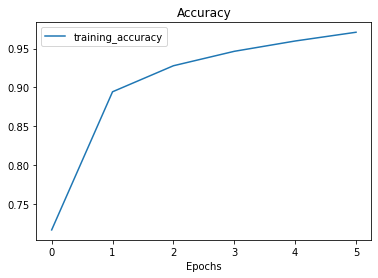

In [16]:
plot_loss_curves(resnet_history)

In [17]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, 
                                              epochs=6,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

2022-01-27 10:03:56.637295: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 10:03:56.637362: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220127-100356


2022-01-27 10:03:56.902096: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-27 10:03:56.902323: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/6
 1/95 [..............................] - ETA: 11:45 - loss: 2.0771 - accuracy: 0.1875

2022-01-27 10:04:05.531573: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-27 10:04:05.531644: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/95 [..............................] - ETA: 1:47 - loss: 2.0302 - accuracy: 0.2344 

2022-01-27 10:04:06.462525: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-27 10:04:06.463852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-27 10:04:06.625095: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 559 callback api events and 556 activity events. 
2022-01-27 10:04:06.662992: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


 3/95 [..............................] - ETA: 1:29 - loss: 1.9913 - accuracy: 0.2500

2022-01-27 10:04:06.684683: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/efficientnetB0/20220127-100356/train/plugins/profile/2022_01_27_10_04_06

2022-01-27 10:04:06.696540: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/efficientnetB0/20220127-100356/train/plugins/profile/2022_01_27_10_04_06/5f62edc346e4.trace.json.gz
2022-01-27 10:04:06.739805: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/efficientnetB0/20220127-100356/train/plugins/profile/2022_01_27_10_04_06

2022-01-27 10:04:06.746761: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorflow_hub/efficientnetB0/20220127-100356/train/plugins/profile/2022_01_27_10_04_06/5f62edc346e4.memory_profile.json.gz
2022-01-27 10:04:06.748835: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Crea

95/95 [==============================] - 30s 238ms/step - loss: 0.9951 - accuracy: 0.7122
Epoch 2/6
95/95 [==============================] - 21s 220ms/step - loss: 0.4760 - accuracy: 0.8847
Epoch 3/6
95/95 [==============================] - 21s 219ms/step - loss: 0.3562 - accuracy: 0.9143
Epoch 4/6
95/95 [==============================] - 21s 222ms/step - loss: 0.2888 - accuracy: 0.9289
Epoch 5/6
95/95 [==============================] - 21s 221ms/step - loss: 0.2473 - accuracy: 0.9365
Epoch 6/6
95/95 [==============================] - 20s 215ms/step - loss: 0.2140 - accuracy: 0.9488


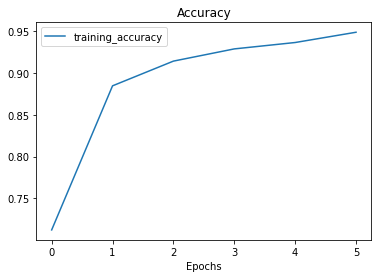

In [18]:
plot_loss_curves(efficientnet_history)